In [ ]:
#default_exp modeling.seq2seq.summarization

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.seq2seq.summarization

> This module contains custom models, custom splitters, etc... summarization tasks.

In [ ]:
#export
import ast, inspect, torch
from typing import Any, Callable, Dict, List, Optional, Union, Type

from datasets import load_metric as hf_load_metric, list_metrics as hf_list_metrics
from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar
from transformers import (
    AutoModelForSeq2SeqLM, logging,
    PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
)

from blurr.utils import BLURR
from blurr.data.seq2seq.core import Seq2SeqTextBlock, Seq2SeqBatchTokenizeTransform
from blurr.modeling.core import BaseModelWrapper, BaseModelCallback, PreCalculatedLoss, Blearner
from blurr.modeling.seq2seq.core import HF_Seq2SeqMetricsCallback, seq2seq_splitter

logging.set_verbosity_error()

In [ ]:
#hide_input
import os, ast, inspect, pdb
from functools import reduce

from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc
from transformers import BartForConditionalGeneration

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("What we're running with at the time this documentation was generated:")
print_versions('torch fastai transformers')

What we're running with at the time this documentation was generated:
torch: 1.7.1
fastai: 2.5.2
transformers: 4.9.2


In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


## Summarization

The objective of summarization is to generate a concise and accurate representation of a much larger body of text.  For example, we may want to summarize an article in a single sentence.

### Prepare the data

In [ ]:
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv'); len(cnndm_df)

1000

In [ ]:
cnndm_df.head(2)

,article,highlights,ds_type
0,"(CNN) -- Globalization washes like a flood over the world's cultures and economies. Floods can be destructive; however, they can also bring blessings, as the annual floods of the Nile did for ancient Egypt. The world's great universities can be crucial instruments in shaping, in a positive way, humankind's reaction to globalization and the development of humankind itself. Traditionally, universities have been defined and limited by location, creating an academic community and drawing students and scholars to that place. Eventually, some universities began to encourage students to study el...","John Sexton: Traditionally, universities have been defined and limited by location .\nGlobal campuses form a network of thought, innovation, he writes .\nFaculty can teach, Sexton says, students can team up in many cities at once .\nSexton: Research, scholarship can be shared and cultural ties made in ""century of knowledge""",train
1,"(CNN) -- Armenian President Robert Kocharian declared a state of emergency Saturday night after a day of clashes between police and protesters, a spokeswoman for the Armenian Foreign Ministry said. Opposition supporters wave an Armenian flag during a protest rally in Yerevan, Armenia, on Saturday. The protesters claim last month's presidential election was rigged. The state of emergency will ""hopefully bring some order"" to the capital, Yerevan, said Salpi Ghazarian, assistant to the Armenian foreign minister, who spoke to CNN early Sunday. The state of emergency could last until March 20, ...","NEW: Protest moves after crackdown at Freedom Square .\nOrder sought after protests over last month's election turn violent .\nDemonstrators say the election was fraudulent .\nState of emergency could last until March 20, official says .",train


In [ ]:
#hide

# pretrained_model_name = "t5-small"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
#                                                                   model_cls=T5ForConditionalGeneration)

# pretrained_model_name = "google/pegasus-cnn_dailymail"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
#                                                                   model_cls=PegasusForConditionalGeneration)

# pretrained_model_name = "facebook/bart-large-cnn"
# hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
#                                                                   model_cls=BartForConditionalGeneration)

In [ ]:
pretrained_model_name = "facebook/bart-large-cnn"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, 
                                                                  model_cls=BartForConditionalGeneration)

hf_arch, type(hf_config), type(hf_tokenizer), type(hf_model)

('bart',
 transformers.models.bart.configuration_bart.BartConfig,
 transformers.models.bart.tokenization_bart_fast.BartTokenizerFast,
 transformers.models.bart.modeling_bart.BartForConditionalGeneration)

In [ ]:
text_gen_kwargs = {}
if (hf_arch in ['bart', 't5']):
    text_gen_kwargs = {**hf_config.task_specific_params['summarization'], **{'max_length': 30, 'min_length': 10}}

# not all "summarization" parameters are for the model.generate method ... remove them here
generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
for k in text_gen_kwargs.copy():
    if k not in generate_func_args: del text_gen_kwargs[k]

if (hf_arch == 'mbart'):
    text_gen_kwargs['decoder_start_token_id'] = hf_tokenizer.get_vocab()["en_XX"]

In [ ]:
tok_kwargs = {}
if (hf_arch == 'mbart'):
    tok_kwargs['src_lang'], tok_kwargs['tgt_lang'] = "en_XX", "en_XX"

In [ ]:
before_batch_tfm = Seq2SeqBatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model, 
                                                  max_length=256, max_target_length=130,
                                                  tok_kwargs=tok_kwargs, text_gen_kwargs=text_gen_kwargs)

blocks = (Seq2SeqTextBlock(before_batch_tfm=before_batch_tfm), noop)

dblock = DataBlock(blocks=blocks, 
                   get_x=ColReader('article'), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

In [ ]:
dls = dblock.dataloaders(cnndm_df, bs=2)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0]['input_ids'].shape, b[1].shape

(2, torch.Size([2, 256]), torch.Size([2, 69]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"<s> (CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence of the country's rich wildlife. And there is a great deal to lose. In the United Nations Environment Program (UNEP) World Conservation Monitoring Centre's list of megadiverse countries Mexico ranks 11th. The list represents a group of 17 countries that harbor the majority of the Earth's species and are therefore considered extremely biodiverse. From its coral reefs in the Caribbean Sea to its tropical jungles in Chiapas and the Yucatan peninsula and its deserts and prairies in the north, Mexico boasts an incredibly rich variety of flora and fauna. Some 574 out of 717 reptile species found in Mexico -- the most in any country -- can only be encountered within its borders. It is home to 502 types of mammals, 290 species of birds, 1,150 varieties of birds and 26,000 classifications of plants. Pronatura, a non-profit organization that works to promote conservation and sustainable development in Mexico, has selected six species which it says symbolize the problems faced by the</s>","Mexico hosts to up to 10 percent of all known species on Earth.\nIt is home to 502 types of mammals, 290 bird species and 26,000 types of plants.\nHuman development and climate change is placing a big strain on its biodiversity.\nThe Golden Eagle is under threat in spite of being the country's national symbol."
1,"<s> Some U.S. officials this year are expected to get smartphones capable of handling classified government documents over cellular networks, according to people involved in the project. The phones will run a modified version of Google's Android software, which is being developed as part of an initiative that spans multiple federal agencies and government contractors, these people said. The smartphones are first being deployed to U.S. soldiers, people familiar with the project said. Later, federal agencies are expected to get phones for sending and receiving government cables while away from their offices, sources said. Eventually, local governments and corporations could give workers phones with similar software. The Army has been testing touchscreen devices at U.S. bases for nearly two years, said Michael McCarthy, a director for the Army's Brigade Modernization Command, in a phone interview. About 40 phones were sent to fighters overseas a year ago, and the Army plans to ship 50 more phones and 75 tablets to soldiers abroad in March, he said. ""We've had kind of an accelerated approval process,"" McCarthy said. ""This is a hugely significant event."" Currently, the United States doesn't allow government workers or soldiers to use smartphones for sending classified messages because the devices have not met security certifications. Officials have said they worry that hackers or</s>","Government, military officials to get Android phones capable of sharing secret documents.\nThe phones will run a modified version of Google's Android software, sources say.\nContractor: Google ""more cooperative"" than Apple working with government on phones."


### Train model

In [ ]:
seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        },
        'bertscore': {
            'compute_kwargs': { 'lang': 'en' },
            'returns': ["precision", "recall", "f1"]
        }
    }

In [ ]:
model = BaseModelWrapper(hf_model)
learn_cbs = [BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), #PreCalculatedLoss()
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)) #.to_native_fp16() #.to_fp16()

learn.freeze()

In [ ]:
#hide
learn.summary()

BaseModelWrapper (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 69 x 1024       
Embedding                                 51470336   False     
Embedding                                 51470336   False     
____________________________________________________________________________
                     2 x 1024            
BartLearnedPositionalEmbedding                      1050624    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
Linear                                    1049600    False     
LayerNorm                                 2048       True      
____________________________________________________________________________
                     2 x 256 x 4096      
Linear                                    4198400    False     
____________________________________

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

len(preds),preds['loss'].shape, preds['logits'].shape

(4, torch.Size([]), torch.Size([2, 79, 50264]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([2, 256]), 2, torch.Size([2, 79]))

In [ ]:
print(len(learn.opt.param_groups))

3


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=6.918309954926372e-05, steep=1.0964781722577754e-06, valley=3.630780702224001e-05, slide=1.4454397387453355e-05)

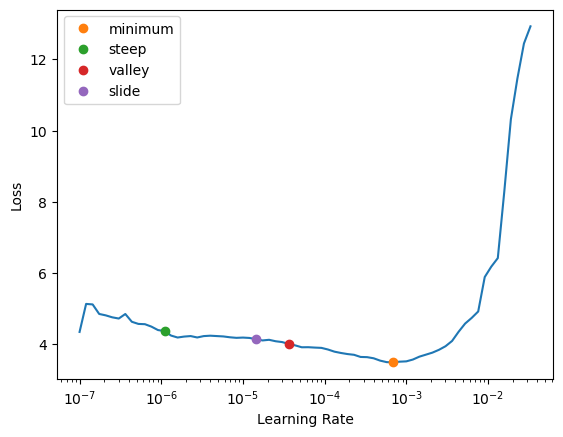

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=4e-5, cbs=fit_cbs)

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.799327,1.663339,0.317453,0.153232,0.252488,0.893058,0.864607,0.878485,02:11


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"(CNN Student News) -- March 23, 2010. Download PDF maps related to today's show:. • Haiti • China. Transcript. THIS IS A RUSH TRANSCRIPT. THIS COPY MAY NOT BE IN ITS FINAL FORM AND MAY BE UPDATED. CARL AZUZ, CNN STUDENT NEWS ANCHOR: Happy birthday, Roger Bannister -- first man to run the mile in less than four minutes. In more than twice that time, you'll be up to speed on today's headlines. I'm Carl Azuz. First Up: Health Care. AZUZ: First up, it's the biggest expansion of the United States he",Find out what comes next after the passage of a health care reform bill.\nLearn about a proposal that would change how student loans are funded.\nFollow the steps that led to a showdown between China and Google.\nUse the Daily Discussion to help studen,Check out the reaction to the U.S. House of Representatives passing a health care reform bill .\nLearn about some of
1,"Washington (CNN)Almost immediately following the news of the first terrorist attacks that eventually killed 17 people across France, the global community united around a Twitter hashtag ""Je suis Charlie"" and just days later foreign leaders linked arms with their French counterparts to lead a historic million-person strong rally. Meanwhile, explosives strapped to a girl who appeared to be about 10-years-old detonated on Saturday, killing at least 20 people, in a country whose encounters with ter","France and Nigeria experienced waves of terrorism during the first weeks of 2015.\nWhile the terror attacks in Paris sparked international unified outrage, reaction to Nigeria was more muted.\nSymbolism, politics and media all played a role in how Fra",Terrorist attacks in Paris and Nigeria fomented unprecedented international reaction .\nThe response to the attacks in Nigeria paled in


In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
outputs = learn.blurr_generate(test_article, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say .
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off into France .
The robbers spoke French and drove vehicles with French lRicense plates .
There were no serious injuries, although one guest was kicked in the head by one of the robbers .

=== Prediction 2 ===
 Robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say .
About 10 men armed with pistols and small machine guns raided the Grand Casino Basel .
The robbers spoke French and drove vehicles with French lRicense plates .
There were no serious injuries, although one guest was kicked in the head by one of the robbers .

=== Prediction 3 ===
 Robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say .
About 10 men armed with pistols and small machine guns 

### Inference

In [ ]:
export_fname = 'summarize_export'

In [ ]:
learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

In [ ]:
inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_article)

[' Robbers made off with several hundred thousand Swiss francs in the early hours of Sunday morning, police say .\nAbout 10']

## High-level API

### BlearnerForSummarization

We also introduce a task specific `Blearner` that get you your DataBlock, DataLoaders, and BLearner in one line of code!

In [ ]:
#hide
try: del learn; del inf_learn; torch.cuda.empty_cache()
except: pass

In [ ]:
#export
@delegates(Blearner.__init__)
class BlearnerForSummarization(Blearner):

    def __init__(
        self, 
        dls: DataLoaders, 
        hf_model: PreTrainedModel, 
        **kwargs
    ):
        super().__init__(dls, hf_model, **kwargs)
            
    @classmethod
    def get_model_cls(cls): 
        return AutoModelForSeq2SeqLM
    
    @classmethod
    def _add_t5_prefix(cls, inp): 
        return f'summarize: {inp}'
    
    @classmethod
    def get_metrics_cb(self):
        seq2seq_metrics = {
            'rouge': {
                'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
                'returns': ["rouge1", "rouge2", "rougeL"]
            },
            'bertscore': {
                'compute_kwargs': { 'lang': 'en' },
                'returns': ["precision", "recall", "f1"]
            }
        }
            
        return HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)
    
    @classmethod
    def _create_learner(
        cls, 
        # Your raw dataset
        data, 
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The attribute in your dataset that contains your raw text
        text_attr:str='text', 
        # The attribute in your dataset that contains your target (summarized) text
        summary_attr:str='summary', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=RandomSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        # we need to find the architecture to ensure "mbart" specific tokenizer kwargs are included
        model_cls = cls.get_model_cls()
        model = model_cls.from_pretrained(pretrained_model_name_or_path)
        hf_arch = BLURR.get_model_architecture(type(model).__name__)

        if (hf_arch == 'mbart'): 
            hf_tok_kwargs = { **{'src_lang': 'en_XX', 'tgt_lang': 'en_XX'}, **hf_tok_kwargs }
            
        # get our hf objects
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name_or_path, 
                                                                          model_cls=model_cls, 
                                                                          tokenizer_kwargs=hf_tok_kwargs)
        
        # if we need to preprocess the raw data before creating our DataLoaders
        if (preprocess_func):
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, text_attr, summary_attr)
            
        # update text generation kwargs
        if (text_gen_kwargs is None and hf_arch in ['bart', 't5']):
            text_gen_kwargs = hf_config.task_specific_params['summarization']
        
        # not all "summarization" parameters are for the model.generate method ... remove them here
        generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
        for k in text_gen_kwargs.copy():
            if k not in generate_func_args: del text_gen_kwargs[k]
                
        # update our text generation kwargs for mbart
        if (hf_arch == 'mbart'):
            text_gen_kwargs = { **{'decoder_start_token_id': 'en_XX'}, **text_gen_kwargs }
            
        # define getters
        if (isinstance(data, pd.DataFrame)):
            get_x = Pipeline(funcs=[ColReader(text_attr)])
            get_y = ColReader(summary_attr)
        else:
            get_x = Pipeline(funcs=[ItemGetter(text_attr)])
            get_y = ItemGetter(summary_attr)
                               
        if (hf_arch == 't5'):
            get_x.add(cls._add_t5_prefix)
            
        # define our DataBlock and DataLoaders
        before_batch_tfm = Seq2SeqBatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                          max_length=max_length, 
                                                          max_target_length=max_target_length, 
                                                          text_gen_kwargs=text_gen_kwargs)
        
        blocks = (Seq2SeqTextBlock(before_batch_tfm=before_batch_tfm), noop)
        dblock = DataBlock(blocks=blocks, 
                           get_x=get_x, 
                           get_y=get_y, 
                           splitter=dblock_splitter)
        
        dls = dblock.dataloaders(data, **dl_kwargs.copy())
        
        # return BLearner instance
        learner_kwargs['splitter'] = learner_kwargs.pop('splitter', partial(seq2seq_splitter, arch=hf_arch))
        learner_kwargs['loss_func'] = learner_kwargs.pop('loss_func', CrossEntropyLossFlat())
        
        return cls(dls, hf_model, **learner_kwargs.copy())
    
    @classmethod
    def from_dataframe(
        cls,
        # Your pandas DataFrame
        df, 
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The attribute in your dataset that contains your raw text
        text_attr:str='text', 
        # The attribute in your dataset that contains your target (summarized) text
        summary_attr:str='summary', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=ColSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        
        return cls._create_learner(df, 
                                   pretrained_model_name_or_path=pretrained_model_name_or_path, 
                                   preprocess_func=preprocess_func, 
                                   text_attr=text_attr, 
                                   summary_attr=summary_attr, 
                                   max_length=max_length, 
                                   max_target_length=max_target_length,  
                                   dblock_splitter=dblock_splitter, 
                                   hf_tok_kwargs=hf_tok_kwargs, text_gen_kwargs=text_gen_kwargs, 
                                   dl_kwargs=dl_kwargs, learner_kwargs=learner_kwargs)
    
        
    @classmethod
    def from_csv(
        cls,
        # The path to your csv file
        csv_file:Union[Path, str],
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The attribute in your dataset that contains your raw text
        text_attr:str='text', 
        # The attribute in your dataset that contains your target (summarized) text
        summary_attr:str='summary', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=ColSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        df = pd.read_csv(csv_file)
        
        return cls.from_dataframe(df, 
                                  pretrained_model_name_or_path=pretrained_model_name_or_path, 
                                  preprocess_func=preprocess_func, 
                                  text_attr=text_attr, 
                                  summary_attr=summary_attr, 
                                  max_length=max_length, 
                                  max_target_length=max_target_length,  
                                  dblock_splitter=dblock_splitter, 
                                  hf_tok_kwargs=hf_tok_kwargs, text_gen_kwargs=text_gen_kwargs, 
                                  dl_kwargs=dl_kwargs, learner_kwargs=learner_kwargs)
    
    @classmethod
    def from_dictionaries(
        cls,
        # A list of dictionaries
        ds:List[Dict], 
        # The name or path of the pretrained model you want to fine-tune
        pretrained_model_name_or_path:Optional[Union[str, os.PathLike]],
        # A function to perform any preprocessing required for your Dataset 
        preprocess_func:Callable=None, 
        # The attribute in your dataset that contains your raw text
        text_attr:str='text', 
        # The attribute in your dataset that contains your target (summarized) text
        summary_attr:str='summary', 
        # The max length of your raw text to consider for summarization
        max_length:Union[int,str]=None, 
        # The max length of your targets (sumamrized) text
        max_target_length:Union[int,str]=None,
        # A function that will split your Dataset into a training and validation set
        # See [here](https://docs.fast.ai/data.transforms.html#Split) for a list of fast.ai splitters
        dblock_splitter:Callable=RandomSplitter(),
        # Any additional keyword arguments applied during tokenization
        hf_tok_kwargs:dict={}, 
        # If you want to override your Blurr transform's `text_gen_kwargs`, do that here
        text_gen_kwargs:dict={}, 
        # Any kwargs to pass to your `DataLoaders`
        dl_kwargs:dict={}, 
        # Any kwargs to pass to your task specific `Blearner`
        learner_kwargs:dict={}
    ):
        return cls._create_learner(ds, 
                                   pretrained_model_name_or_path=pretrained_model_name_or_path, 
                                   preprocess_func=preprocess_func, 
                                   text_attr=text_attr, 
                                   summary_attr=summary_attr, 
                                   max_length=max_length, 
                                   max_target_length=max_target_length,  
                                   dblock_splitter=dblock_splitter, 
                                   hf_tok_kwargs=hf_tok_kwargs, text_gen_kwargs=text_gen_kwargs, 
                                   dl_kwargs=dl_kwargs, learner_kwargs=learner_kwargs)
    

In [ ]:
learn = BlearnerForSummarization.from_dataframe(cnndm_df, 'facebook/bart-large-cnn', 
                                                text_attr='article', summary_attr='highlights', 
                                                max_length=256, max_target_length=130,
                                                dblock_splitter=RandomSplitter(),
                                                dl_kwargs={'bs':2}).to_fp16()

In [ ]:
learn.fit_one_cycle(1, lr_max=4e-5, cbs=[BlearnerForSummarization.get_metrics_cb()])

epoch,train_loss,valid_loss,rouge1,rouge2,rougeL,bertscore_precision,bertscore_recall,bertscore_f1,time
0,1.680803,1.656284,0.391191,0.175432,0.271317,0.876456,0.893137,0.884638,03:50


In [ ]:
learn.show_results(learner=learn, input_trunc_at=500, target_trunc_at=250)

,text,target,prediction
0,"(CNN Student News) -- March 23, 2010. Download PDF maps related to today's show:. • Haiti • China. Transcript. THIS IS A RUSH TRANSCRIPT. THIS COPY MAY NOT BE IN ITS FINAL FORM AND MAY BE UPDATED. CARL AZUZ, CNN STUDENT NEWS ANCHOR: Happy birthday, Roger Bannister -- first man to run the mile in less than four minutes. In more than twice that time, you'll be up to speed on today's headlines. I'm Carl Azuz. First Up: Health Care. AZUZ: First up, it's the biggest expansion of the United States he",Find out what comes next after the passage of a health care reform bill.\nLearn about a proposal that would change how student loans are funded.\nFollow the steps that led to a showdown between China and Google.\nUse the Daily Discussion to help studen,Find out why the U.S. House of Representatives passed a health care reform bill late Sunday night .\nCheck out some of the reaction to last night's vote on the health care issue .\nLearn about the impact of the earthquake in Haiti .\nMeet a man who is
1,"(CNN Student News) -- Parents and Teachers: Watch with your students or record ""Gary + Tony Have a Baby"" when it airs on CNN on Thursday, June 24 at 8 p.m. ET. By recording the documentary, you agree that you will use the program for educational viewing purposes for a one-year period only. No other rights of any kind or nature whatsoever are granted, including, without limitation, any rights to sell, publish, distribute, post online or distribute in any other medium or forum, or use for any com","""Gary + Tony Have a Baby"" is a documentary that follows the journey of a gay couple as they attempt to become parents.\nParents and educators can use this guide to initiate discussion with students about the documentary.","""Gary + Tony Have a Baby"" is a documentary that follows the journey of a gay couple as they attempt to become parents .\nWe recommend that you preview this program and determine whether it is appropriate before showing it to students .\nBy recording t"


In [ ]:
test_article = """
About 10 men armed with pistols and small machine guns raided a casino in Switzerland and made off 
into France with several hundred thousand Swiss francs in the early hours of Sunday morning, police said. 
The men, dressed in black clothes and black ski masks, split into two groups during the raid on the Grand Casino 
Basel, Chief Inspector Peter Gill told CNN. One group tried to break into the casino's vault on the lower level 
but could not get in, but they did rob the cashier of the money that was not secured, he said. The second group 
of armed robbers entered the upper level where the roulette and blackjack tables are located and robbed the 
cashier there, he said. As the thieves were leaving the casino, a woman driving by and unaware of what was 
occurring unknowingly blocked the armed robbers' vehicles. A gunman pulled the woman from her vehicle, beat 
her, and took off for the French border. The other gunmen followed into France, which is only about 100 
meters (yards) from the casino, Gill said. There were about 600 people in the casino at the time of the robbery. 
There were no serious injuries, although one guest on the Casino floor was kicked in the head by one of the 
robbers when he moved, the police officer said. Swiss authorities are working closely with French authorities, 
Gill said. The robbers spoke French and drove vehicles with French lRicense plates. CNN's Andreena Narayan 
contributed to this report.
"""

In [ ]:
outputs = learn.blurr_generate(test_article, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
 Police: About 10 men armed with pistols and machine guns raided a casino in Switzerland .
They made off with several hundred thousand Swiss francs in the early hours of Sunday morning .
The robbers spoke French and drove vehicles with French lRicense plates .
There were no serious injuries, but one guest was kicked in the head by one of the robbers .

=== Prediction 2 ===
 Police: About 10 men armed with pistols and machine guns raided a casino in Switzerland .
They made off with several hundred thousand Swiss francs in the early hours of Sunday morning .
The robbers spoke French and drove vehicles with French lRicense plates .
There were no serious injuries, although one guest was kicked in the head by one of the robbers .

=== Prediction 3 ===
 Police: About 10 men armed with pistols and machine guns raided a casino in Switzerland .
They made off with several hundred thousand Swiss francs in the early hours of Sunday morning .
The robbers spoke French and drove 

In [ ]:
export_fname = 'summarize_export'

learn.metrics = None
learn.export(fname=f'{export_fname}.pkl')

inf_learn = load_learner(fname=f'{export_fname}.pkl')
inf_learn.blurr_generate(test_article)

[' Police: About 10 men armed with pistols and machine guns raided a casino in Switzerland .\nThey made off with several hundred thousand Swiss francs in the early hours of Sunday morning .\nThe robbers spoke French and drove vehicles with French lRicense plates .\nThere were no serious injuries, but one guest was kicked in the head by one of the robbers .']

## Tests

The purpose of the following tests is to ensure as much as possible, that the core training code works for the pretrained **summarization models** below.  These tests are excluded from the CI workflow because of how long they would take to run and the amount of data that would be required to download.

**Note**: Feel free to modify the code below to test whatever pretrained summarization models you are working with ... and if any of your pretrained summarization models fail, please submit a github issue *(or a PR if you'd like to fix it yourself)*

In [ ]:
#hide
try: del learn; del inf_learn; torch.cuda.empty_cache()
except: pass

In [ ]:
#hide
[ model_type for model_type in BLURR.get_models(task='ConditionalGeneration') 
 if (not model_type.startswith('TF')) ]

['BartForConditionalGeneration',
 'BigBirdPegasusForConditionalGeneration',
 'BlenderbotForConditionalGeneration',
 'BlenderbotSmallForConditionalGeneration',
 'FSMTForConditionalGeneration',
 'LEDForConditionalGeneration',
 'M2M100ForConditionalGeneration',
 'MBartForConditionalGeneration',
 'MT5ForConditionalGeneration',
 'PegasusForConditionalGeneration',
 'ProphetNetForConditionalGeneration',
 'Speech2TextForConditionalGeneration',
 'T5ForConditionalGeneration',
 'XLMProphetNetForConditionalGeneration']

In [ ]:
#hide
pretrained_model_names = [
    'facebook/bart-base',
    #'facebook/blenderbot_small-90M',
    'allenai/led-base-16384',
    'sshleifer/tiny-mbart',
    'google/mt5-small',
    'sshleifer/distill-pegasus-cnn-16-4',
    't5-small', 
    #'microsoft/prophetnet-large-uncased',
    #'microsoft/xprophetnet-large-wiki100-cased', # XLMProphetNet
]

In [ ]:
#hide
path = Path('./')
cnndm_df = pd.read_csv(path/'cnndm_sample.csv')

In [ ]:
#hide
model_cls = AutoModelForSeq2SeqLM
bsz = 2
inp_seq_sz = 64; trg_seq_sz = 40

test_results = []
for model_name in pretrained_model_names:
    error=None
    
    print(f'=== {model_name} ===\n')
    
    hf_tok_kwargs = {}
    if (model_name == 'sshleifer/tiny-mbart'):
        hf_tok_kwargs['src_lang'], hf_tok_kwargs['tgt_lang'] = "en_XX", "en_XX"
    
    hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(model_name, 
                                                                      model_cls=model_cls, 
                                                                      tokenizer_kwargs=hf_tok_kwargs)
    
    print(f'architecture:\t{hf_arch}\ntokenizer:\t{type(hf_tokenizer).__name__}\nmodel:\t\t{type(hf_model).__name__}\n')

    # 1. build your DataBlock
    text_gen_kwargs = {}
    if (hf_arch in ['bart', 't5']):
        text_gen_kwargs = {**hf_config.task_specific_params['summarization'], **{'max_length': 30, 'min_length': 10}}
    
    # not all "summarization" parameters are for the model.generate method ... remove them here
    generate_func_args = list(inspect.signature(hf_model.generate).parameters.keys())
    for k in text_gen_kwargs.copy():
        if k not in generate_func_args: del text_gen_kwargs[k]
            
    if (hf_arch == 'mbart'):
        text_gen_kwargs['decoder_start_token_id'] = hf_tokenizer.get_vocab()["en_XX"]
            
            
    def add_t5_prefix(inp): return f'summarize: {inp}' if (hf_arch == 't5') else inp
    
    before_batch_tfm = Seq2SeqBatchTokenizeTransform(hf_arch, hf_config, hf_tokenizer, hf_model,
                                                      padding='max_length', 
                                                      max_length=inp_seq_sz, 
                                                      max_target_length=trg_seq_sz, 
                                                      text_gen_kwargs=text_gen_kwargs)
    
    blocks = (Seq2SeqTextBlock(before_batch_tfm=before_batch_tfm), noop)
    dblock = DataBlock(blocks=blocks, 
                   get_x=Pipeline([ColReader('article'), add_t5_prefix]), 
                   get_y=ColReader('highlights'), 
                   splitter=RandomSplitter())

    dls = dblock.dataloaders(cnndm_df, bs=bsz) 
    b = dls.one_batch()

    # 2. build your Learner
    seq2seq_metrics = {
        'rouge': {
            'compute_kwargs': { 'rouge_types': ["rouge1", "rouge2", "rougeL"], 'use_stemmer': True },
            'returns': ["rouge1", "rouge2", "rougeL"]
        }
    }
    
    model = BaseModelWrapper(hf_model)
    learn_cbs = [BaseModelCallback]
    fit_cbs = [
        ShortEpochCallback(0.05, short_valid=True), 
        HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)
    ]
 
    learn = Learner(dls, 
                    model,
                    opt_func=ranger,
                    loss_func=PreCalculatedLoss(),
                    cbs=learn_cbs,
                    splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

    learn.create_opt() 
    learn.freeze()
    
    # 3. Run your tests
    try:
        print('*** TESTING DataLoaders ***\n')
        test_eq(len(b), 2)
        test_eq(len(b[0]['input_ids']), bsz)
        test_eq(b[0]['input_ids'].shape, torch.Size([bsz, inp_seq_sz]))
        test_eq(len(b[1]), bsz)

#         print('*** TESTING One pass through the model ***')
#         preds = learn.model(b[0])
#         test_eq(preds[1].shape[0], bsz)
#         test_eq(preds[1].shape[2], hf_config.vocab_size)

        print('*** TESTING Training/Results ***')
        learn.fit_one_cycle(1, lr_max=1e-3, cbs=fit_cbs)

        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'PASSED', ''))
        learn.show_results(learner=learn, max_n=2, input_trunc_at=500, target_trunc_at=250)
    except Exception as err:
        test_results.append((hf_arch, type(hf_tokenizer).__name__, type(hf_model).__name__, 'FAILED', err))
    finally:
        # cleanup
        del learn; torch.cuda.empty_cache()

=== facebook/bart-base ===

architecture:	bart
tokenizer:	BartTokenizerFast
model:		BartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Washington (CNN)Almost immediately following the news of the first terrorist attacks that eventually killed 17 people across France, the global community united around a Twitter hashtag ""Je suis Charlie"" and just days later foreign leaders linked arms with their French counterparts to lead a historic million-person strong rally. Meanwhile, explosives strapped","France and Nigeria experienced waves of terrorism during the first weeks of 2015.\nWhile the terror attacks in Paris sparked international unified outrage, reaction to Nigeria was more muted.\nSymbolism,","Washington (CNN)Almost immediately following the news of the first terrorist attacks that eventually killed 17 people across France, the global community united around"
1,"Michael Zehaf-Bibeau, the 32-year-old gunman who attacked the Canadian Parliament and killed a soldier last week, had a familiar profile. It is that of a young man alienated from mainstream society, with few friends, without a steady job, drifting from one place to another -- often","Like many ""lone wolf"" terrorists, Ottawa gunman was alienated drifter who converted to Islam.\nConversion to militant Islam is often about seeking identity, purpose or adventure.\nSome","Michael Zehaf-Bibeau, the 32-year-old gunman who attacked the Canadian Parliament and killed a soldier last week"


=== allenai/led-base-16384 ===

architecture:	led
tokenizer:	LEDTokenizerFast
model:		LEDForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"Some U.S. officials this year are expected to get smartphones capable of handling classified government documents over cellular networks, according to people involved in the project. The phones will run a modified version of Google's Android software, which is being developed as part of an initiative that spans multiple federal agencies and government contractors,","Government, military officials to get Android phones capable of sharing secret documents.\nThe phones will run a modified version of Google's Android software, sources say.\nContractor: Google ""more",Some U.S. officials this year are expected to get smartphones capable of handling classified government
1,"(CNN) -- Wondering where to go for your next holiday? Experts explain which destinations we should be checking out in 2014. Brazil: The World Cup. The modern game of football, or soccer, may have been born in England's public schools, but many will claim its soul has settled in Brazil.",New Zealand government threw $50 million into the construction of the Nga Haerenga cycle trails.\nNosara in Costa Rica recently awarded a Blue Flag -- a certification awarded to,(CNN) -- Wondering where to go for your next holiday? Experts explain which destinations


=== sshleifer/tiny-mbart ===

architecture:	mbart
tokenizer:	MBartTokenizerFast
model:		MBartForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"(CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence of","Mexico hosts to up to 10 percent of all known species on Earth. It is home to 502 types of mammals, 290 bird species and 26,000 types of plants",เข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไป
1,"Police missed speaking with suspected Los Angeles International Airport shooter Paul Ciancia by ""a matter of minutes"" the day his family asked authorities to check on him after receiving disturbing messages, according to the chairman of the House Homeland Security Committee. By the time officers arrived at Ciancia's",Paul Ciancia began asking for a ride to the airport days before the shooting. Police performing a welfare check at his family's request missed him by less than an hour,เข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไปเข้าไป


=== google/mt5-small ===

architecture:	mt5
tokenizer:	T5TokenizerFast
model:		MT5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"(CNN) -- Home to up to 10 percent of all known species, Mexico is recognized as one of the most biodiverse regions on the planet. The twin threats of climate change and human encroachment on natural environments are, however, threatening the existence","Mexico hosts to up to 10 percent of all known species on Earth. It is home to 502 types of mammals, 290 bird species and 26,000 types of",<extra_id_0>.
1,"(CNN) -- To Disney or not to Disney? For many travelers, especially those with children, it's not even a question they ask. They already know the answer. ""Yes."" To these visitors, Disney is Mickey Mouse, princesses,",Disney represents magical stories and fun family to fans. Some parents delight in their children's wonder during a first visit to Disney. Some critics think the,<extra_id_0>.


=== sshleifer/distill-pegasus-cnn-16-4 ===

architecture:	pegasus
tokenizer:	PegasusTokenizerFast
model:		PegasusForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"London (CNN) -- In 1948, a hospital outside London witnessed the birth of the Paralympic movement, as a Jewish doctor who had fled Nazi Germany sought to change the lives of patients with spinal injuries -- and inspire new hope in them through sport. The first ""Stoke Mandeville Games"" were organized in 1948 to coincide with the","Paralympic movement was born in Stoke Mandeville, outside London, in 1948. 2012 Games will be the biggest yet, with 4,200 competitors from 165 countries. In an echo of the first,","The first ""Stoke Mandeville Games"" was organized in 1948 . The first ""Stoke Mandeville Games"" was organized in 1948 ."
1,"(CNN Student News) -- March 23, 2010. Download PDF maps related to today's show:. • Haiti • China. Transcript. THIS IS A RUSH TRANSCRIPT. THIS COPY MAY NOT BE IN ITS FINAL FORM AND MAY BE UPDATED. CARL AZUZ, CNN",Find out what comes next after the passage of a health care reform bill. Learn about a proposal that would change how student loans are funded. Follow the steps that led to a showdown between,Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News . Use the weekly Newsquiz to test your knowledge of stories you saw on CNN Student News .


=== t5-small ===

architecture:	t5
tokenizer:	T5TokenizerFast
model:		T5ForConditionalGeneration

*** TESTING DataLoaders ***

*** TESTING Training/Results ***


,text,target,prediction
0,"summarize: (CNN) -- It's a congested, sprawling transport hub surrounded by 1950s architecture and predominantly used by commuters or tourists to cross the city of Istanbul. But proposed changes to Taksim Square have seen it become the flashpoint for protests that have",Taksim Square was where Istanbul's water was distributed -- Taksim means divide. The site is seen as symbolizing the seclar Turkish republic founded by Ataturk.,"it's a congested, sprawling transport hub surrounded by 1950s architecture . proposed changes to Taksim Square have"
1,"summarize: (CNN) -- Two years after the United States pulled its forces out of Iraq, the country is, in the words of one analyst, ""a house of cards."" ""It is a contraption held together solely by the reluctance of its many components to let","Sectarian divisions, terror, regional conflict and economic issues all threaten Iraqi stability. Continued violence could also threaten the country's oil exports and economy. All these","two years after the united states pulled its forces out of Iraq, the country is ""a house of cards"" one analyst says it is a"


In [ ]:
#hide_input
test_results_df = pd.DataFrame(test_results, columns=['arch', 'tokenizer', 'model_name', 'result', 'error'])
display_df(test_results_df)

,arch,tokenizer,model_name,result,error
0,bart,BartTokenizerFast,BartForConditionalGeneration,PASSED,
1,led,LEDTokenizerFast,LEDForConditionalGeneration,PASSED,
2,mbart,MBartTokenizerFast,MBartForConditionalGeneration,PASSED,
3,mt5,T5TokenizerFast,MT5ForConditionalGeneration,PASSED,
4,pegasus,PegasusTokenizerFast,PegasusForConditionalGeneration,PASSED,
5,t5,T5TokenizerFast,T5ForConditionalGeneration,PASSED,


## Summary

This module includes the fundamental bits to use Blurr for summarization tasks training and inference.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted 99e_examples-causal-lm-gpt2.ipynb.
Converted index.ipynb.
